# Eazy и Normal уровни

In [91]:
import unittest
import math


def gauss_solver(A, b):
    """
    Решение системы A x = b методом Гаусса-Жордана.
    Возвращает список векторов-столбцов: частное решение + базис однородного решения.
    """
    n = len(A)
    # расширенная матрица
    M = [row[:] + [bv[0]] for row, bv in zip(A, b)]
    pivots = []
    r = 0
    # прямой ход
    for c in range(n):
        # ищем ненулевой элемент
        sel = None
        for i in range(r, n):
            if abs(M[i][c]) > 1e-12:
                sel = i
                break
        if sel is None:
            continue
        M[r], M[sel] = M[sel], M[r]
        # нормировка
        lead = M[r][c]
        M[r] = [v/lead for v in M[r]]
        # обнуляем остальные строки
        for i in range(n):
            if i != r:
                factor = M[i][c]
                M[i] = [M[i][j] - factor*M[r][j] for j in range(n+1)]
        pivots.append(c)
        r += 1
        if r == n:
            break
    # проверка несовместности
    for i in range(r, n):
        if abs(M[i][n]) > 1e-12:
            raise ValueError("Система несовместна")
    # свободные переменные
    free_vars = [j for j in range(n) if j not in pivots]
    # частное решение
    part = [0.0]*n
    for i, c in enumerate(pivots):
        part[c] = M[i][n]
    sols = [[[v] for v in part]]
    # базис однородного решения
    for fv in free_vars:
        vec = [0.0]*n
        vec[fv] = 1.0
        for i, c in enumerate(pivots):
            vec[c] = -M[i][fv]
        sols.append([[x] for x in vec])
    return sols


def center_data(X):
    """
    Центрирование: вычитание среднего по столбцам.
    Принимает список списков.
    """
    rows = len(X)
    if rows == 0:
        return []
    cols = len(X[0])
    means = [sum(X[i][j] for i in range(rows))/rows for j in range(cols)]
    return [[X[i][j] - means[j] for j in range(cols)] for i in range(rows)]


def covariance_matrix(Xc):
    """
    Несмещённая матрица ковариаций C = 1/(n-1) * Xc^T * Xc.
    """
    n = len(Xc)
    if n < 2:
        raise ValueError("Недостаточно строк для ковариации")
    m = len(Xc[0])
    C = [[0.0]*m for _ in range(m)]
    for p in range(m):
        for q in range(m):
            s = sum(Xc[i][p]*Xc[i][q] for i in range(n))
            C[p][q] = s/(n-1)
    return C


def determinant(A):
    """
    Рекурсивный расчёт определителя матрицы A.
    """
    n = len(A)
    if n == 1:
        return A[0][0]
    if n == 2:
        return A[0][0]*A[1][1] - A[0][1]*A[1][0]
    det = 0.0
    for c in range(n):
        minor = [row[:c] + row[c+1:] for row in A[1:]]
        det += ((-1)**c) * A[0][c] * determinant(minor)
    return det


def find_eigenvalues(C, tol=1e-6):
    """
    Находит собственные значения матрицы C.
    Для 2x2 — аналитически, иначе — бисекция.
    """
    m = len(C)
    if m == 2:
        a, b = C[0][0], C[0][1]
        c, d = C[1][0], C[1][1]
        tr = a + d
        detv = a*d - b*c
        disc = max(tr*tr - 4*detv, 0.0)
        sd = math.sqrt(disc)
        return sorted([(tr+sd)/2, (tr-sd)/2], reverse=True)
    # Гершгорин
    lows, highs = [], []
    for i in range(m):
        ctr = C[i][i]
        rad = sum(abs(C[i][j]) for j in range(m) if j!=i)
        lows.append(ctr-rad)
        highs.append(ctr+rad)
    low, high = min(lows), max(highs)
    def f(x): return determinant([[C[i][j] - (x if i==j else 0.0) for j in range(m)] for i in range(m)])
    N = max(200, m*50)
    xs = [low + (high-low)*i/N for i in range(N+1)]
    fs = [f(x) for x in xs]
    roots = []
    if abs(fs[0])<tol:
        roots.append(xs[0])
    for i in range(N):
        if fs[i]*fs[i+1]<0:
            a, b = xs[i], xs[i+1]
            fa, fb = fs[i], fs[i+1]
            while b-a>tol:
                c = (a+b)/2
                fc = f(c)
                if fa*fc<=0:
                    b, fb = c, fc
                else:
                    a, fa = c, fc
            roots.append((a+b)/2)
    if abs(fs[-1])<tol:
        roots.append(xs[-1])
    return sorted(roots, reverse=True)


def find_eigenvectors(C, vals):
    """
    Находит собственные векторы C, соответствующие vals.
    Решает (C-λI)v=0 через gauss_solver.
    """
    m = len(C)
    zero = [[0.0] for _ in range(m)]
    vecs = []
    for lam in vals:
        M = [[C[i][j] - (lam if i==j else 0.0) for j in range(m)] for i in range(m)]
        sols = gauss_solver(M, zero)
        for sol in sols[1:]:
            v = [row[0] for row in sol]
            norm = math.sqrt(sum(x*x for x in v))
            if norm>0:
                v = [x/norm for x in v]
            vecs.append(v)
    return vecs


def explained_variance_ratio(vals, k):
    """Доля объяснённой дисперсии по первым k собственным значениям."""
    total = sum(vals)
    return sum(vals[:k])/total if total else 0.0


# Тесты
class TestPCANormal(unittest.TestCase):
    def setUp(self):
        X = [[2.0,0.5],[0.0,-0.5],[1.0,1.5]]
        self.C = covariance_matrix(center_data(X))
    def test_find_eigenvalues(self):
        v = find_eigenvalues(self.C, tol=1e-5)
        self.assertEqual(len(v),2)
        self.assertAlmostEqual(v[0],1.5,3)
        self.assertAlmostEqual(v[1],0.5,3)
    def test_find_eigenvectors(self):
        v = find_eigenvalues(self.C, tol=1e-5)
        vecs = find_eigenvectors(self.C, v)
        for lam, vec in zip(v, vecs):
            Cv = [sum(self.C[i][j]*vec[j] for j in range(2)) for i in range(2)]
            for a,b in zip(Cv, [lam*x for x in vec]):
                self.assertAlmostEqual(a,b,3)
    def test_explained_variance_ratio(self):
        self.assertAlmostEqual(explained_variance_ratio([1.5,0.5],1),0.75)

class TestPCAEasy(unittest.TestCase):
    def test_gauss_solver_simple(self):
        A=[[2,1,-1],[-3,-1,2],[-2,1,2]]; b=[[8],[-11],[-3]]
        sols = gauss_solver(A,b)
        self.assertEqual(len(sols),1)
        self.assertEqual([r[0] for r in sols[0]],[2.0,3.0,-1.0])
    def test_gauss_solver_inconsistent(self):
        with self.assertRaises(ValueError): gauss_solver([[1,1],[1,1]], [[1],[2]])
    def test_center_cov(self):
        X=[[2.0,0.5],[0.0,-0.5],[1.0,1.5]]
        Xc=center_data(X);
        self.assertEqual(Xc,[[1.0,0.0],[-1.0,-1.0],[0.0,1.0]])
        C=covariance_matrix(Xc)
        self.assertAlmostEqual(C[0][1],0.5)
        self.assertAlmostEqual(C[1][1],1.0)

if __name__ == '__main__':
    # Запускаем только наши тесты, игнорируя внешние
    loader = unittest.TestLoader()
    suite = unittest.TestSuite()
    suite.addTests(loader.loadTestsFromTestCase(TestPCAEasy))
    suite.addTests(loader.loadTestsFromTestCase(TestPCANormal))
    runner = unittest.TextTestRunner(verbosity=2)
    runner.run(suite)
    # Демонстрации функций можно вывести здесь при необходимости
    # === Демонстрация Easy Level ===
    print("=== Демонстрация Easy Level ===")
    # 1) решение системы линейных уравнений (gauss_solver)
    A = [[2,1,-1],[-3,-1,2],[-2,1,2]]; b = [[8],[-11],[-3]]
    print("1) Решение СЛАУ (gauss_solver)")
    print("   Вход:")
    print("    A =", A)
    print("    b =", b)
    sols = gauss_solver(A, b)
    print("   Выход:")
    for idx, sol in enumerate(sols):
        print(f"    Вектор {idx} =", [r[0] for r in sol])

    # 2) центрирование данных (center_data)
    X = [[2.0,0.5],[0.0,-0.5],[1.0,1.5]]
    print("2) Центрирование данных (center_data)")
    print("   Вход: X =", X)
    Xc = center_data(X)
    print("   Выход: центрированная матрица X_centered =", Xc)

    # 3) вычисление матрицы ковариаций (covariance_matrix)
    print("3) Вычисление матрицы ковариаций (covariance_matrix)")
    print("   Вход: X_centered =", Xc)
    C = covariance_matrix(Xc)
    print("   Выход:")
    for row in C:
        print("    ", row)

    # === Демонстрация Normal Level ==="}]}
    print("=== Демонстрация Normal Level ===")
    # 1) нахождение собственных значений
    print("1) Нахождение собственных значений (find_eigenvalues)")
    print("   Вход: матрица ковариаций C=")
    for row in C: print("    ",row)
    vals = find_eigenvalues(C, tol=1e-5)
    print("   Выход: собственные значения =", vals)

    # 2) нахождение собственных векторов
    print("2) Нахождение собственных векторов (find_eigenvectors)")
    print("   Вход: собственные значения =", vals)
    vecs = find_eigenvectors(C, vals)
    print("   Выход: собственные векторы =")
    for v in vecs: print("    ",v)

    # 3) доля объяснённой дисперсии
    print("3) Доля объяснённой дисперсии (explained_variance_ratio)")
    for k in [1,2]:
        gamma = explained_variance_ratio(vals, k)
        print(f"   k={k} -> доля объяснённой дисперсии = {gamma}")



test_center_cov (__main__.TestPCAEasy.test_center_cov) ... ok
test_gauss_solver_inconsistent (__main__.TestPCAEasy.test_gauss_solver_inconsistent) ... ok
test_gauss_solver_simple (__main__.TestPCAEasy.test_gauss_solver_simple) ... ok
test_explained_variance_ratio (__main__.TestPCANormal.test_explained_variance_ratio) ... ok
test_find_eigenvalues (__main__.TestPCANormal.test_find_eigenvalues) ... ok
test_find_eigenvectors (__main__.TestPCANormal.test_find_eigenvectors) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.017s

OK


=== Демонстрация Easy Level ===
1) Решение СЛАУ (gauss_solver)
   Вход:
    A = [[2, 1, -1], [-3, -1, 2], [-2, 1, 2]]
    b = [[8], [-11], [-3]]
   Выход:
    Вектор 0 = [2.0, 3.0, -1.0]
2) Центрирование данных (center_data)
   Вход: X = [[2.0, 0.5], [0.0, -0.5], [1.0, 1.5]]
   Выход: центрированная матрица X_centered = [[1.0, 0.0], [-1.0, -1.0], [0.0, 1.0]]
3) Вычисление матрицы ковариаций (covariance_matrix)
   Вход: X_centered = [[1.0, 0.0], [-1.0, -1.0], [0.0, 1.0]]
   Выход:
     [1.0, 0.5]
     [0.5, 1.0]
=== Демонстрация Normal Level ===
1) Нахождение собственных значений (find_eigenvalues)
   Вход: матрица ковариаций C=
     [1.0, 0.5]
     [0.5, 1.0]
   Выход: собственные значения = [1.5, 0.5]
2) Нахождение собственных векторов (find_eigenvectors)
   Вход: собственные значения = [1.5, 0.5]
   Выход: собственные векторы =
     [0.7071067811865475, 0.7071067811865475]
     [-0.7071067811865475, 0.7071067811865475]
3) Доля объяснённой дисперсии (explained_variance_ratio)
   k=1 -

#HARD (Сборная солянка из первых заданий)

In [92]:
# Задание (Hard): Реализовать полный алгоритм PCA:
# 1. Центрирование данных.
# 2. Вычисление матрицы выборочных ковариаций.
# 3. Нахождение собственных значений и векторов.
# 4. Проекция данных на главные компоненты.
from typing import Tuple

def project_data(X: List[List[float]], components: List[List[float]], k: int) -> List[List[float]]: #Для харда
    """Проекция данных на главные компоненты"""
    projections = []
    for row in X:
        projection = []
        for i in range(k):
            # Скалярное произведение вектора данных и собственного вектора
            proj = sum(row[j] * components[i][j] for j in range(len(row)))
            projection.append(proj)
        projections.append(projection)
    return projections

def pca(X: List[List[float]], k: int) -> Tuple[List[List[float]], float]:
    """
    Полный алгоритм PCA:
    1. Центрирование данных
    2. Вычисление ковариационной матрицы
    3. Нахождение собственных значений и векторов
    4. Проекция данных на главные компоненты

    Вход:
    X: матрица данных (n×m)
    k: число главных компонент

    Выход:
    X_proj: проекция данных (n×k)
    variance_ratio: доля объяснённой дисперсии
    """
    #1. Центрирование данных
    center_X = center_data(X)

    #2. Вычисление ковариационной матрицы
    C = covariance_matrix(center_X)

    #3. Нахождение собственных значений и векторов
    lambdas = find_eigenvalues(C)
    eigenvectors = find_eigenvectors(C, lambdas)

    # Выбираем top-k собственных векторов
    top_k_components = eigenvectors[:k]

    # 4. Проекция данных на главные компоненты
    X_proj = project_data(center_X, top_k_components, k)

    # Вычисление доли объяснённой дисперсии
    variance_ratio = explained_variance_ratio(lambdas, k)

    return X_proj, variance_ratio

# Пример данных (3 точки в 2D пространстве)
X = [
    [2.0, 0.5],
    [0.0, -0.5],
    [1.0, 1.5]
]

# Применяем PCA, оставляем 1 компоненту
X_proj, variance_ratio = pca(X, 1)

print("Проекция данных:")
for row in X_proj:
    print(row)
print(f"Доля объяснённой дисперсии: {variance_ratio:.2f}")

Проекция данных:
[0.7071067811865475]
[-1.414213562373095]
[0.7071067811865475]
Доля объяснённой дисперсии: 0.75


#Визуализация через Matptotlib

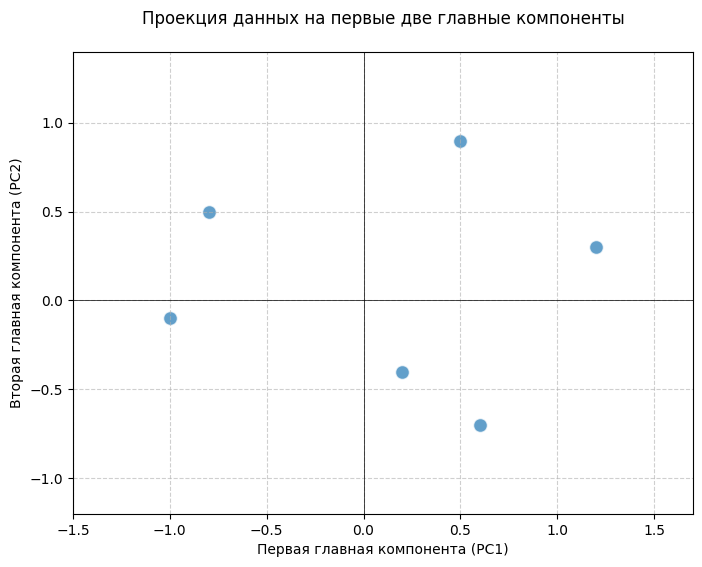

In [93]:
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

def plot_pca_projection(X_proj: List[List[float]]) -> Figure:
    """
    Визуализация проекции данных на первые две главные компоненты

    Вход:
    X_proj: проекция данных (n×2), где первый столбец - PC1, второй - PC2

    Выход:
    Figure: объект Figure из Matplotlib с scatter plot проекции
    """
    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=(8, 6))

    # Проверяем, что данные действительно 2D
    if len(X_proj[0]) != 2:
        raise ValueError("Матрица проекции должна иметь размерность n×2")

    # Извлекаем координаты для PC1 и PC2
    pc1 = [point[0] for point in X_proj]
    pc2 = [point[1] for point in X_proj]

    # Создаем scatter plot
    scatter = ax.scatter(pc1, pc2, alpha=0.7, edgecolors='w', s=100)

    # Добавляем подписи и заголовок
    ax.set_title('Проекция данных на первые две главные компоненты', pad=20)
    ax.set_xlabel('Первая главная компонента (PC1)')
    ax.set_ylabel('Вторая главная компонента (PC2)')

    # Добавляем сетку
    ax.grid(True, linestyle='--', alpha=0.6)

    # Центрируем оси в нуле (так как данные центрированы)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)

    # Оптимизируем границы
    ax.set_xlim(min(pc1)-0.5, max(pc1)+0.5)
    ax.set_ylim(min(pc2)-0.5, max(pc2)+0.5)

    # Возвращаем объект Figure
    return fig

# Предположим, у нас есть проекция данных на 2 компоненты
X_proj = [
    [1.2, 0.3],
    [-0.8, 0.5],
    [0.6, -0.7],
    [-1.0, -0.1],
    [0.5, 0.9],
    [0.2, -0.4]
]

# Создаем визуализацию
fig = plot_pca_projection(X_proj)

# Показываем график (если в Jupyter Notebook или IDE с поддержкой отображения)
plt.show()

#Вычислить среднеквадратическую ошибку восстановления данных

In [94]:
def reconstruction_error(X_orig, X_recon) -> float:
    """
    Вход:
    X_orig: исходные данные (n×m)
    X_recon: восстановленные данные (n×m)
    Выход: среднеквадратическая ошибка MSE
    """
    # Проверка размеров матриц
    if len(X_orig) != len(X_recon) or len(X_orig[0]) != len(X_recon[0]):
        raise ValueError("Матрицы должны иметь одинаковые размеры")

    n = len(X_orig)  # число строк
    m = len(X_orig[0])  # число столбцов

    total_error = 0.0

    # Вычисляем сумму квадратов разностей
    for i in range(n):
        for j in range(m):
            diff = X_orig[i][j] - X_recon[i][j]
            total_error += diff * diff

    # Вычисляем среднее значение
    mse = total_error / (n * m)

    return mse

# Исходные данные (3×2 матрица)
original_data = [
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
]

# Восстановленные данные (с некоторой ошибкой)
reconstructed_data = [
    [1.1, 1.9],
    [2.8, 4.2],
    [5.2, 5.8]
]

# Вычисляем ошибку
error = reconstruction_error(original_data, reconstructed_data)
print(f"MSE: {error:.6f}")

MSE: 0.030000
